<span style="font-size:16pt">
<p style="text-align: center;">
    МИНОБРНАУКИ РОССИИ <br>
    РГУ НЕФТИ И ГАЗА (НИУ) ИМЕНИ И.М. ГУБКИНА<br>
    ФАКУЛЬТЕТ АВТОМАТИКИ И ВЫЧИСЛИТЕЛЬНОЙ ТЕХНИКИ<br>
    КАФЕДРА АВТОМАТИЗИРОВАННЫХ СИСТЕМ УПРАВЛЕНИЯ<br>  <br>
    ДИСЦИПЛИНА <br>
        «Теория принятия решений. Нечеткие модели»
    <br><br> <br> <br> <br> <br>
    ОТЧЁТ <br>
    по лабораторной работе №6 <br>
    «Аппроксимация с использованием модели ANFIS»<br> <br> <br> <br> <br>  <br><br>
</p>

<p style="text-align: right;">
    Выполнил:<br>
    студент группы АС-21-05, Негробов В.А.<br>
    Проверил:<br>
    Манзюк Н.Ю.<br><br> <br> <br> <br> <br><br> <br> <br>

<p style="text-align: center;">
    МОСКВА 2025
</p>
   </span>

# Подключение библиотек, настройка NumPy и PyTorch

In [27]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Работа модели ANFIS

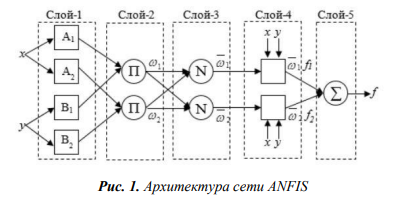

### Архитектура ANFIS

#### Слой 1
В узлах данного слоя происходит процедура **фаззификации**. Определяются нечеткие термы для входных параметров.  
Входами слоя служат чёткие переменные \( x, y \).  
Выходами слоя являются значения функций принадлежности $ \mu_A(x) $ и $ \mu_B(y) $.  
Каждый узел слоя является **адаптивным**.

#### Слой 2
Определяет посылки нечетких правил.  
Данный слой — **неадаптивный**.  
Каждый узел соединён с теми узлами первого слоя, которые формируют предпосылки соответствующего правила.  
Элементы слоя выполняют агрегирование степеней истинности предпосылок каждого правила в соответствии с операцией **T-нормы**, в качестве которой может выступать операция минимума:

$$
\alpha_i = \sup \left\{ \min \left[ \mu_A(x), T\mu_R(x, y) \right] \right\}
$$

Выходами нейронов этого слоя являются **степени истинности** посылок каждого правила базы знаний системы.

#### Слой 3
Осуществляет **нормализацию** уровней активации правил.  
Неадаптивные узлы этого слоя рассчитывают относительную степень (вес) выполнения нечеткого правила по формуле:

$$
\beta_i = \frac{\alpha_i}{\sum \alpha_i}, \quad i = 1, \dots, n
$$

#### Слой 4
В этом слое реализуется модель нечеткого логического вывода **Такаги–Сугено**.  
Данный узел является **адаптивным**.  
Здесь вычисляются значения заключений по каждому правилу:

$$
O_i = \beta_i f_i = \beta_i (p_i x + q_i y + r_i)
$$

где $ p_i, q_i, r_i $ — параметры заключений.

#### Слой 5
Единственный **неадаптивный** узел этого слоя вычисляет окончательное значение на выходе ANFIS путём суммирования результатов предыдущего слоя:

$$
y = \frac{\sum \beta_i f_i}{\sum \beta_i}
$$

# Создание искусственных данных с шумами

Задача - аппроксимация функции

$$
F(x_1, x_2) = x_1 * x_2,
$$
где 
$x_1, x_2 \in [0, 1]$

К данным добавляется нормально распределённый шум с математическим ожиданием 0 и стандартным отклонением 0.1. Значение mse 0.1 - Байесовская ошибка

In [28]:
# 1. Генерация данных
def generate_data(num_samples):
    """
    Функция для генерации данных
    Args:
        num_samples (int): количество точек данных
    Returns:
        X (np.ndarray): массив признаков (num_samples, 2)
        y (np.ndarray): массив целевых значений (num_samples,)
    """
    rng = (0, 1)
    X = np.random.rand(num_samples, 2) * (rng[1] - rng[0]) + rng[0]
    y = X[:, 0] * X[:, 1] + np.random.randn(num_samples) / 10
    return X, y
X, y = generate_data(int(1e6))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2 , random_state=SEED)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800000, 2), (200000, 2), (800000,), (200000,))

# Реализация ANFIS

In [29]:
# 2. Определяем слои Гауссовых ФП
class GaussianMF(nn.Module):
    """Гауссова функция принадлежности"""
    def __init__(self, mu, sigma):
        """
        Создание сигмоидальной функции принадлежности
        Args:
            mu (float): среднее значение (центр) ФП
            sigma (float): стандартное отклонение ФП
        Returns:
           None
        """
        super().__init__()
        # Обучаемые параметры
        self.mu = nn.Parameter(torch.tensor(mu, dtype=torch.float32))
        self.sigma = nn.Parameter(torch.tensor(sigma, dtype=torch.float32))

    def forward(self, x):
    # x: (batch,1)
        return torch.exp(-((x - self.mu)**2) / (2 * self.sigma**2 + 1e-6))

In [30]:
# 3. Реализация ANFIS‑модели
class ANFIS(nn.Module):
    def __init__(self, n_inputs, n_mfs):
        """
        n_inputs: число входов (2)
        n_mfs: список длины n_inputs
        """
        super().__init__()
        self.n_inputs = n_inputs
        self.n_mfs = n_mfs
        # 3.1. Создаём по n_mfs[i] Гауссовых ФП для каждого входа
        self.mfs = nn.ModuleList()
        for i in range(n_inputs):
            mfs_for_input = nn.ModuleList([
                GaussianMF(torch.rand(1).item(), torch.rand(1).item())
                for _ in range(n_mfs[i])
            ])
            self.mfs.append(mfs_for_input)
        # 3.2. Параметры для каждого правила: p_i, q_i, r_i
        # число правил = prod(n_mfs)
        from itertools import product
        self.rule_indices = list(product(*[range(m) for m in n_mfs]))
        n_rules = len(self.rule_indices)
        self.p = nn.Parameter(torch.randn(n_rules))
        self.q = nn.Parameter(torch.randn(n_rules))
        self.r = nn.Parameter(torch.randn(n_rules))
    def forward(self, x):
        """
        x: tensor (batch, n_inputs)
        возвращает y: tensor (batch,)
        """
        batch_size = x.shape[0]
        # 1) Степени принадлежности: для каждого входа i получаем (batch, n_mfs[i])
        mu_list = []
        for i in range(self.n_inputs):
            xi = x[:, i].unsqueeze(1)
            # конкатенируем все ФП по второму измерению
            mus = torch.cat([mf(xi) for mf in self.mfs[i]], dim=1)
            mu_list.append(mus)
        # 2) Вычисляем вес каждого правила

        W = []
        for idx in self.rule_indices:
            w = mu_list[0][:, idx[0]]
            for i in range(1, self.n_inputs):
                w = w * mu_list[i][:, idx[i]]
            W.append(w.unsqueeze(1))
        W = torch.cat(W, dim=1)
        # 3) Нормализация
        W_sum = W.sum(dim=1, keepdim=True) + 1e-6
        W_norm = W / W_sum
        # 4) Линейные выходы каждого правила: f_i = p_i*x1 + q_i*x2 + r_i
        # p, q, r: (n_rules,)
        f_list = []
        for i, (p, q, r) in enumerate(zip(self.p, self.q, self.r)):
            f = p * x[:, 0] + q * x[:, 1] + r  # (batch,)
            f_list.append(f.unsqueeze(1))
        f = torch.cat(f_list, dim=1)  # (batch, n_rules)
        # 5) Итоговый выход
        y = (W_norm * f).sum(dim=1)
        return y

# Обучение ANFIS

In [31]:
# 4. Инициализация модели, оптимизатор и критерий
model = ANFIS(n_inputs=2, n_mfs=[2,2]).to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-1)
criterion = nn.MSELoss()

In [32]:
def mse(outputs, yb):
    """
    Среднеквадратичная ошибка
    Args:
       outputs (torch.Tensor): предсказания модели (batch_size, 1)
       yb (torch.Tensor): истинные значения (batch_size, 1)
    Returns:
       torch.Tensor: среднеквадратичная ошибка (1,)
    """
    return ((outputs - yb) ** 2).mean()

In [33]:
# Преобразование данных в тензоры

X_train_t, X_test_t, y_train_t, y_test_t = (
    torch.from_numpy(X_train).to(device),
    torch.from_numpy(X_test).to(device),
    torch.from_numpy(y_train).to(device),
    torch.from_numpy(y_test).to(device)
)

### Тренировочный цикл модели

Модель обучается в течение 300 эпох. На каждой итерации выполняются следующие шаги:

1. **Переход в режим обучения**: модель переводится в состояние, позволяющее обновлять параметры.
2. **Прямой проход**: вычисляются предсказания модели на обучающем наборе данных.
3. **Вычисление ошибки**: используется функция среднеквадратичной ошибки (MSE) между предсказанными и истинными значениями.
4. **Обратное распространение ошибки**: градиенты рассчитываются и применяются для обновления параметров модели через оптимизатор.
5. **Сохранение значения ошибки**: значение функции потерь сохраняется в список `train_losses` для последующего анализа.

После этого модель переводится в **режим оценки**, и выполняется аналогичная процедура на тестовом наборе данных. Полученное значение ошибки сохраняется в список `test_losses`.

In [34]:
train_losses = list()
test_losses = list()

# 5. Обучение
for epoch in range(1, 300 + 1):
    print(f'{epoch = }')
    model.train()
    optimizer.zero_grad()
    preds = model(X_train_t)
    loss = mse(preds, y_train_t)
    loss.backward()
    optimizer.step() 
    print(f'train loss: {loss.item()}')
    train_losses.append(loss.item())
    model.eval()
    with torch.no_grad():
        preds = model(X_test_t)
    loss = mse(preds, y_test_t)
    print(f'test loss: {loss.item()}')
    test_losses.append(loss.item())

epoch = 1
train loss: 1.9080911673327676
test loss: 0.5652733887808111
epoch = 2
train loss: 0.5671000327581003
test loss: 0.1632849469988183
epoch = 3
train loss: 0.16322131354891084
test loss: 0.22000940635380262
epoch = 4
train loss: 0.21888768736160202
test loss: 0.24049812882247565
epoch = 5
train loss: 0.23914222721808215
test loss: 0.16500087847777148
epoch = 6
train loss: 0.16393062570096262
test loss: 0.08258589366825378
epoch = 7
train loss: 0.08193748431862846
test loss: 0.0408584022106838
epoch = 8
train loss: 0.04048342574037474
test loss: 0.02500537379959243
epoch = 9
train loss: 0.02476595733627702
test loss: 0.020616099360420158
epoch = 10
train loss: 0.020445328579925582
test loss: 0.022331246987003502
epoch = 11
train loss: 0.02219677905296762
test loss: 0.026902645260714324
epoch = 12
train loss: 0.02678493208098554
test loss: 0.030846816377244634
epoch = 13
train loss: 0.030732199194958405
test loss: 0.031989645260208074
epoch = 14
train loss: 0.031869235302110985
t

Значение ошибки равно Байесовскому, значит модель практически идеально аппроксимирует данные

In [35]:
# 6. Оценка на тесте
mse_test = test_losses[-1]
rmse_test = test_losses[-1]**0.5
print(f"Test MSE: {mse_test:.5f}, RMSE: {rmse_test:.5f}")

Test MSE: 0.01007, RMSE: 0.10034


Визуализация критерия МНК для тренировочной и  и тестовой выборки. Видно, что кривая обучения и кривая теста совпадают, что говорит о том, что модель не переобучилась

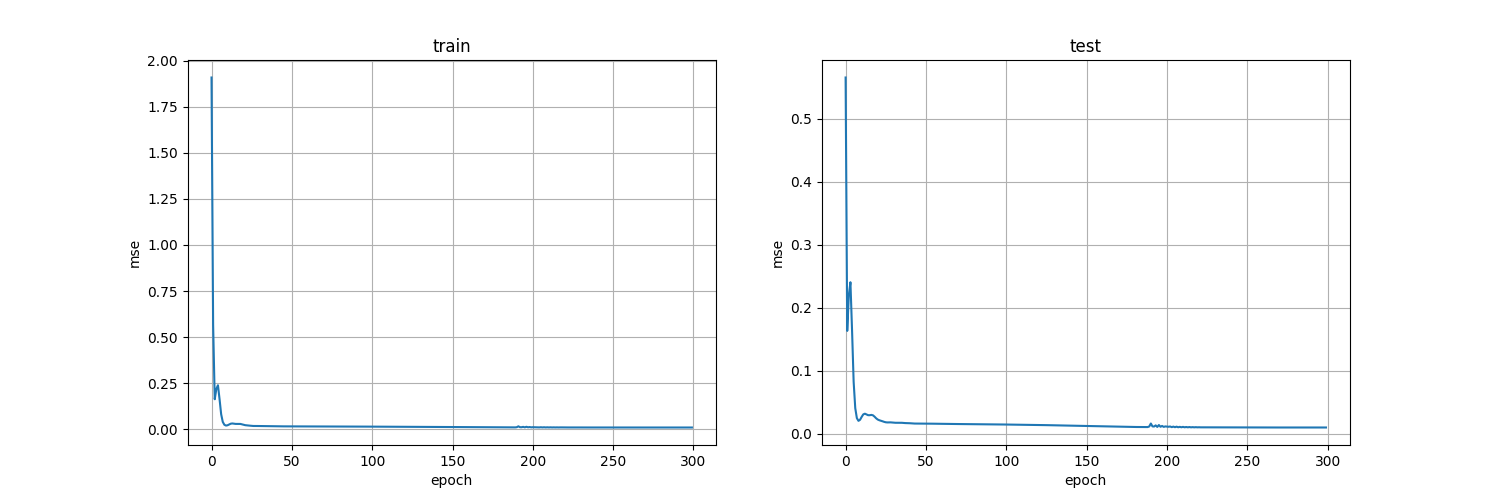

In [36]:
# 7. Визуализация результатов
# 7.1. Кривая обучения
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(train_losses)
axs[0].set_title('train')
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('mse')
axs[0].grid()

axs[1].plot(test_losses)
axs[1].set_title('test')
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('mse')
axs[1].grid()

Визуализация плоскости для визуальной оценки схожести истинных и предсказанных значений. Видно, что модель хорошо аппроксимирует зависимос

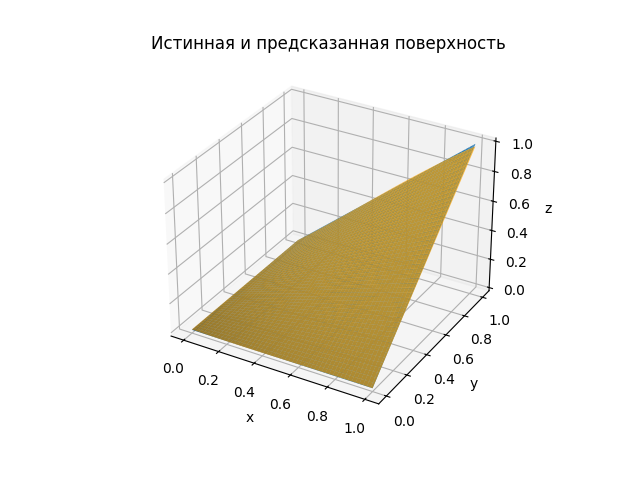

In [39]:
%matplotlib widget
# 7.2. Истинные vs предсказанные

# 1. Сетка
X, Y = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))

# 2. Истинные значения
Z = X * Y  # или любая другая реальная зависимость

# 3. Подготовка к предсказанию
XY = np.stack([X.ravel(), Y.ravel()], axis=1)  # (10000, 2)
XY_tensor = torch.from_numpy(XY).to(device).float()       # (10000, 2), dtype float32

# 4. Предсказания
with torch.no_grad():
    Z_predicted = model(XY_tensor).cpu().numpy().reshape(100, 100)

# 5. Построение 3D-графика
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.plot_surface(X, Y, Z, alpha=0.9, label='True')
ax.plot_surface(X, Y, Z_predicted, color='orange', alpha=0.7, label='Predicted')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.title("Истинная и предсказанная поверхность")
plt.show()

Визуализация функций принадлежности входного слоя

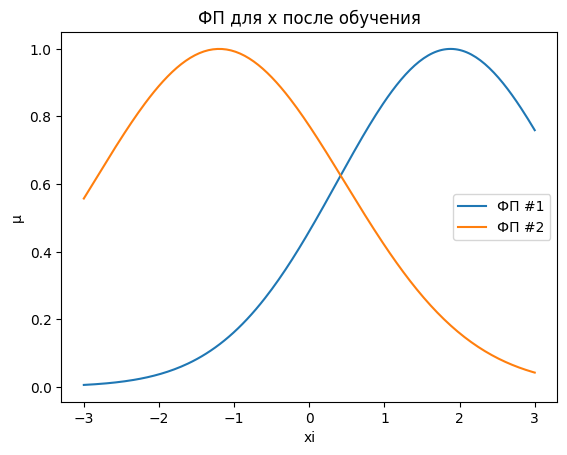

In [41]:
%matplotlib inline
# 7.3. Функции принадлежности до и после обучения (для первого входа)
x_grid = torch.linspace(-3,3,200).unsqueeze(1).to(device)
plt.figure()
for idx, mf in enumerate(model.mfs[0]):
    # Вычисляем значения ФП после обучения и отсоединяем от графа
    y_after = mf(x_grid).detach().cpu().numpy().flatten()
    # Метка по индексу ФП
    plt.plot(x_grid.cpu().numpy(), y_after, label=f"ФП #{idx+1}")
plt.xlabel('xi')
plt.ylabel('μ')
plt.title('ФП для x после обучения')
plt.legend()